In [123]:
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

In [2]:
# Parameters
DATES = pd.date_range('2020-09', '2020-10', freq='D', closed='left')

# DATES_PROCESS = pd.date_range('2020-10', '2021-', freq='D', closed='left')
# DATES_PROCESS = DATES_PROCESS[:int(0.25*len(DATES))]

### only focus on the last 7 days of August

DEVICE_INFP1 = 'devuse_4known_device.csv000.gz'
DEVICE_OUTFP1 = 'sample2_device_1.csv'

DEVICE_INFP2 = 'devuse_4known_device.csv001.gz'
DEVICE_OUTFP2 = 'sample2_device_2.csv'

BATTERY_EVENT_INFP = 'batt_acdc_events.csv000.gz'
BATTERY_EVENT_OUTFP = 'sample2_events.csv'

BATTERY_INFO_INFP = 'batt_info.csv000.gz'
BATTERY_INFO_OUTFP = 'sample2_info.csv'

PROCESS_INFP1 = 'plist_process_resource_util_13wks.csv000.gz'
PROCESS_OUTFP1 = 'sample2_process_1.csv'

PROCESS_INFP2 = 'plist_process_resource_util_13wks.csv001.gz'
PROCESS_OUTFP2 = 'sample2_process_2.csv'



PROCESS_INFP3 = 'plist_process_resource_util_hist.csv001.gz'
PROCESS_OUTFP3 = 'sample2_process_3.csv'

PROCESS_INFP4 = 'plist_process_resource_util_hist.csv002.gz'
PROCESS_OUTFP4 = 'sample2_process_4.csv'

PROCESS_INFP5 = 'plist_process_resource_util_hist.csv003.gz'
PROCESS_OUTFP5 = 'sample2_process_5.csv'



HW_INFP1 = 'hw_metric_histo.csv000.gz'
HW_OUTFP1 = 'sample2_hw_1.csv'

HW_INFP2 = 'hw_metric_histo.csv001.gz'
HW_OUTFP2 = 'sample2_hw_2.csv'

In [3]:
DATES

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', freq='D')

In [42]:
def find_seperator(infp):
    with gzip.open(infp,'rt') as f:
        count = 0
        for line in f:
            if count == 0:
                toreplace = line[7] 
                count+=1
            else:
                break
    return toreplace

def device_filtered(dates, infp, outfp):
    seperator = find_seperator(infp)
    
    pd.read_csv(infp, compression='gzip'\
            ,sep=seperator, nrows=0).to_csv(outfp, index=False) # read column names


    for counter, chunk in enumerate(pd.read_csv(infp,
                            compression='gzip', sep=seperator,dtype=str, chunksize=1000000,error_bad_lines=False)):
        print(counter)
        try:
            device_use = chunk.loc[chunk.device == 'GUID_DEVICE_BATTERY']
            device_use.dt = pd.to_datetime(device_use.dt, errors='coerce')
            needed_time = set(dates).intersection(set(device_use.dt))
            filtered = device_use.set_index('dt').loc[needed_time].reset_index()
        except:
            display(chunk.dt.min(),chunk.dt.max())
            continue
        filtered.to_csv(outfp, index=False, header=False, mode='a')
    return 


def battery_filtered(needed_guid, dates, infp, outfp):
    seperator = find_seperator(infp)
    pd.read_csv(infp, compression='gzip'\
                ,sep=seperator, nrows=0).to_csv(outfp, index=False) # read column names

    
    if 'process'in infp:
        dt = 'start_dt'
        flagprocess = True
    else:
        dt = 'dt'
        flagprocess = False
        
        
    if 'events' in infp:
        flagevent = True
    else:
        flagevent = False
    
    if 'hw' in infp:
        flaghw = True
    else:
        flaghw = False
        
    for counter, chunk in enumerate(pd.read_csv(infp,
                            compression='gzip', sep=seperator,dtype=str, \
                                                chunksize=1000000,error_bad_lines = False)):
        print(counter)
#         display(chunk.head().T)
        try:
            needed = set(needed_guid).intersection(set(chunk.guid))
            chunk = chunk.set_index('guid').loc[needed].reset_index()
            chunk[dt] = pd.to_datetime(chunk[dt],errors='coerce')
            needed_time = set(dates).intersection(set(chunk[dt]))
            filtered = chunk.set_index(dt).loc[needed_time].reset_index()
        except:
            display(chunk[dt].min(),chunk[dt].max())
            continue
        
        if flagevent:
            filtered = filtered.loc[filtered.event_type == 'DC']
            
            
        if flaghw:
            cpu_percent = filtered.name == 'HW::CORE:C0:PERCENT:'
            temperature = filtered.name == 'HW::CORE:TEMPERATURE:CENTIGRADE:'
            filtered = filtered.loc[cpu_percent | temperature ]
#             display(filtered)
        
            

    
        filtered.to_csv(outfp, index=True, header=False, mode='a')
    return 
        

In [6]:
# df31 = pd.read_csv('mini_device_use1.csv')
# df41 = pd.read_csv('mini_device_use2.csv')
# mini_device_use = df41.append(df31)
# newcol = ['dt', 'load_ts', 'batch_id', 'audit_zip', 'audit_internal_path', 'guid',
#        'interval_start_utc', 'interval_end_utc', 'interval_local_start',
#        'interval_local_end', 'ts','device', 'hw_name', 'name',
#        'duration', 'status']
# mini_device_use.columns = newcol

In [7]:
# mini_needed_guids = set(mini_device_use.guid)
# len(mini_needed_guids)

In [8]:
# #battery_filtered(mini_needed_guids, DATES, PROCESS_INFP1, 'mini_process1.csv')
# battery_filtered(mini_needed_guids, DATES, PROCESS_INFP2, 'mini_process2.csv')

# #battery_filtered(needed_guids, DATES, HW_INFP1, HW_OUTFP1)
# #battery_filtered(needed_guids, DATES, HW_INFP2, HW_OUTFP2)

In [9]:
# battery_filtered(mini_needed_guids, DATES, HW_INFP1, 'mini_hw1.csv')

In [10]:
# battery_filtered(mini_needed_guids, DATES, HW_INFP2, 'mini_hw2.csv')

In [11]:
# battery_filtered(mini_needed_guids, DATES, BATTERY_EVENT_INFP, 'mini_battery_event2.csv')

In [12]:
# battery_filtered(mini_needed_guids, DATES, BATTERY_INFO_INFP, 'mini_battery_info2.csv')

In [13]:
# mini_device_use[0:20000].to_csv('minimini_device_use1.csv')
# mini_device_use[20000:40000].to_csv('minimini_device_use2.csv')
# pd.read_csv('mini_process1.csv', nrows = 20000).to_csv('minimini_process1.csv')
# pd.read_csv('mini_process2.csv', nrows = 20000).to_csv('minimini_process2.csv')
# pd.read_csv('mini_hw1.csv', nrows = 20000).to_csv('minimini_hw1.csv')
# pd.read_csv('mini_hw2.csv', nrows = 20000).to_csv('minimini_hw2.csv')
# pd.read_csv('mini_battery_event2.csv', nrows = 20000).to_csv('minimini_battery_event2.csv')
# pd.read_csv('mini_battery_info2.csv', nrows = 20000).to_csv('minimini_battery_info2.csv')

# Problem Focus:
Build a model for predicting ` battery remaining time ` based on features we mined

# Read Data

### <font color='red'> NOTICE: FOR THIS PART, If you don't have sample data, then you can run it; else, skip READ Data Part</font>

Selected Datasets are:
* ` batt_acdc_events.csv000.gz `
* ` batt_info.csv000.gz `
* `devuse_4known_device.csv000.gz` and `devuse_4known_device.csv001`
* ` plist_process_resource_util_13wks.csv000.gz ` and ` plist_process_resource_util_13wks.csv001.gz `
* ` hw_metric_histo.csv000.gz ` and `hw_metric_histo.csv001.gz`

### Call device_filtered to get guid with our needed features:

1. device_use, GUID_DEVICE_BATTERY & date in DATES --> needed_guid1 (#~40369)

In [6]:
#Read first device file
# device_filtered(DATES, DEVICE_INFP1, DEVICE_OUTFP1)

In [7]:
#read second device file
# device_filtered(DATES, DEVICE_INFP2, DEVICE_OUTFP2)

In [4]:
df3 = pd.read_csv(DEVICE_OUTFP1)
df4 = pd.read_csv(DEVICE_OUTFP2)
device_use = df4.append(df3)
newcol = ['dt', 'load_ts', 'batch_id', 'audit_zip', 'audit_internal_path', 'guid',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','device', 'hw_name', 'name',
       'duration', 'status']
device_use.columns = newcol
needed_guids = set(device_use.guid)

In [5]:
len(set(device_use.guid))

40369

2. to batterey_events --> get only dc battery --> update needed guid1 (~32931)

In [10]:
## read battery_events file
# battery_filtered(needed_guids, DATES, BATTERY_EVENT_INFP, BATTERY_EVENT_OUTFP)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


In [6]:

battery_event = pd.read_csv(BATTERY_EVENT_OUTFP)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','system_power_state', 'event_type',
       'duration', 'battery_percent_remaining', 'battery_minutes_remaining']
battery_event.columns = newcol
needed_guids = set(battery_event.guid) ## update needed guids, and then load other datasets

# battery_filtered(needed_guids, DATES, BATTERY_INFO_INFP, BATTERY_INFO_OUTFP)

# battery_filtered(needed_guids, DATES, PROCESS_INFP1, PROCESS_OUTFP1)
#battery_filtered(needed_guids, DATES, PROCESS_INFP2, PROCESS_OUTFP2)

#battery_filtered(needed_guids, DATES, HW_INFP1, HW_OUTFP1)
# battery_filtered(needed_guids, DATES, HW_INFP2, HW_OUTFP2)

In [7]:
len(set(battery_event.guid))

32931

3. to battery_info --> # of guids (32906）

In [13]:
## read battery_info file (needed_guids (#~))
# battery_filtered(needed_guids, DATES, BATTERY_INFO_INFP, BATTERY_INFO_OUTFP)

In [8]:
battery_info = pd.read_csv(BATTERY_INFO_OUTFP)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','battery_enum', 'chemistry',
       'designed_capacity', 'full_charge_capacity', 'battery_count']
battery_info.columns = newcol

In [9]:
len(set(battery_info.guid))

32906

3. to process --> #of guids(2747)

NOTES: For this dataset, since we don't have data from september, so we extract data from oct to Dec.

In [11]:
DATES_PROCESS = pd.date_range('2020-10', '2020-12', freq='D', closed='left')

In [95]:
# battery_filtered(needed_guids, DATES_PROCESS, PROCESS_INFP1, PROCESS_OUTFP1)

In [12]:
process = pd.read_csv(PROCESS_OUTFP1)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path','interval_start_utc', 
 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','proc_name', 'exe_hash',
       'num_runs', 'ttl_run_tm_in_ms', 'cpu_user_sec', 'cpu_kernel_sec',
       'io_bytes_read', 'io_bytes_write', 'io_bytes_other', 'page_faults',
       'hard_page_faults', 'disk_read_iobytes', 'disk_write_iobytes',
       'tcpip_sendbytes', 'tcpip_receivebytes', 'udpip_sendbytes',
       'udpip_receivebytes', 'avg_memory', 'peak_memory']
process.columns = newcol
process

,dt,guid,load_ts,batch_id,audit_zip,audit_internal_path,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,...,page_faults,hard_page_faults,disk_read_iobytes,disk_write_iobytes,tcpip_sendbytes,tcpip_receivebytes,udpip_sendbytes,udpip_receivebytes,avg_memory,peak_memory
0,2020-10-09,0337df40320046868541387de9a4604a,2020-10-11 05:12:55,20201010-200234,2020101101-i-04a9a906e1cd5620c-iKxevjMEAxdo87a...,V8PLIST_20201010211124.V8,2020-10-10 00:13:13,2020-10-11 01:11:40,2020-10-09 20:13:13,2020-10-10 21:11:40,...,3111.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,3521.00,3940.0
1,2020-10-09,0337df40320046868541387de9a4604a,2020-10-11 05:12:55,20201010-200234,2020101101-i-04a9a906e1cd5620c-iKxevjMEAxdo87a...,V8PLIST_20201010211124.V8,2020-10-10 00:13:13,2020-10-11 01:11:40,2020-10-09 20:13:13,2020-10-10 21:11:40,...,3839.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7390.00,7692.0
2,2020-10-09,0337df40320046868541387de9a4604a,2020-10-11 05:12:55,20201010-200234,2020101101-i-04a9a906e1cd5620c-iKxevjMEAxdo87a...,V8PLIST_20201010211124.V8,2020-10-10 00:13:13,2020-10-11 01:11:40,2020-10-09 20:13:13,2020-10-10 21:11:40,...,5222.0,34.0,567808.0,77824.0,1390.0,6700.0,0.0,0.0,4610.50,9856.0
3,2020-10-09,0337df40320046868541387de9a4604a,2020-10-11 05:12:55,20201010-200234,2020101101-i-04a9a906e1cd5620c-iKxevjMEAxdo87a...,V8PLIST_20201010211124.V8,2020-10-10 00:13:13,2020-10-11 01:11:40,2020-10-09 20:13:13,2020-10-10 21:11:40,...,134836.0,113.0,25563136.0,1294336.0,941.0,4407.0,31.0,136.0,24556.00,62092.0
4,2020-10-09,0337df40320046868541387de9a4604a,2020-10-11 05:12:55,20201010-200234,2020101101-i-04a9a906e1cd5620c-iKxevjMEAxdo87a...,V8PLIST_20201010211124.V8,2020-10-10 00:13:13,2020-10-11 01:11:40,2020-10-09 20:13:13,2020-10-10 21:11:40,...,250028.0,46.0,27904000.0,14118912.0,16489.0,925957.0,38762.0,9695629.0,22974.40,110468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2020-11-25,fb32b796280049769bfa89e6f54b1871,2021-01-08 06:07:58,20210107-190233,2021010717-i-0728cf8ab79db9e58-M1WyLGi5xwS6Obe...,V8PLIST_20210107094614.V8,2020-11-20 17:00:09,2021-01-07 16:40:49,2020-11-20 10:00:09,2021-01-07 09:40:49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
535,2020-11-25,fb32b796280049769bfa89e6f54b1871,2021-01-08 06:07:58,20210107-190233,2021010717-i-0728cf8ab79db9e58-M1WyLGi5xwS6Obe...,V8PLIST_20210107094614.V8,2020-11-20 17:00:09,2021-01-07 16:40:49,2020-11-20 10:00:09,2021-01-07 09:40:49,...,3407.0,1231.0,0.0,3653632.0,0.0,0.0,0.0,0.0,1423.00,10728.0
536,2020-11-25,fb32b796280049769bfa89e6f54b1871,2021-01-08 06:07:58,20210107-190233,2021010717-i-0728cf8ab79db9e58-M1WyLGi5xwS6Obe...,V8PLIST_20210107094614.V8,2020-11-20 17:00:09,2021-01-07 16:40:49,2020-11-20 10:00:09,2021-01-07 09:40:49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,2020-11-25,fb32b796280049769bfa89e6f54b1871,2021-01-08 06:07:58,20210107-190233,2021010717-i-0728cf8ab79db9e58-M1WyLGi5xwS6Obe...,V8PLIST_20210107094614.V8,2020-11-20 17:00:09,2021-01-07 16:40:49,2020-11-20 10:00:09,2021-01-07 09:40:49,...,4594.0,221.0,2357760.0,8192.0,0.0,0.0,0.0,0.0,11444.00,13812.0


In [13]:
len(set(process.guid))

2817

5. read cpu file --> # guids 26640

In [29]:
# battery_filtered(needed_guids, DATES, HW_INFP1, HW_OUTFP1)

In [30]:
# battery_filtered(needed_guids, DATES, HW_INFP2, HW_OUTFP2)

In [14]:
cpu1 = pd.read_csv(HW_OUTFP1)
cpu2 = pd.read_csv(HW_OUTFP2)
cpu = cpu1.append(cpu2)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'name', 'instance', 'nrs', 'mean',
       'histogram_min', 'histogram_max', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
       'bin_5', 'bin_6', 'bin_7', 'bin_8', 'bin_9', 'bin_10',
       'metric_max_val']
cpu.columns = newcol

In [15]:
len(set(cpu.guid))

26640

# EDA

In [16]:
print('device_use: '+ str((device_use.dt.min(),device_use.dt.max())))
print('device_use guid #: '+ str(len(set(device_use.guid))))

print('battery_event: '+ str((battery_event.dt.min(),battery_event.dt.max())))
print('battery_event guid #: '+ str(len(set(battery_event.guid))))

print('battery_info: '+ str((battery_info.dt.min(),battery_info.dt.max())))
print('battery_info guid #: '+ str(len(set(battery_info.guid))))

print('process: '+ str((process.dt.min(),process.dt.max())))
print('process guid #: '+ str(len(set(process.guid))))

print('cpu: '+ str((cpu.dt.min(),cpu.dt.max())))
print('cpu guid #: '+ str(len(set(cpu.guid))))


device_use: ('2020-09-01', '2020-09-30')
device_use guid #: 40369
battery_event: ('2020-09-01', '2020-09-30')
battery_event guid #: 32931
battery_info: ('2020-09-01', '2020-09-30')
battery_info guid #: 32906
process: ('2020-10-09', '2020-11-30')
process guid #: 2817
cpu: ('2020-09-01', '2020-09-30')
cpu guid #: 26640


After extracting data from zip files, those are guids we have for each dataset.

## First guessing: ` battery minutes remaining ` is related with ` number of devices `

## - device_use Dataset

Before doing regression analysis on number of devices, we anticipate that there would be a low correlation between battery minutes remaining and number of devices as Teams suggest us that different devices would require defferent level of power to run.

In [17]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

data2 = device_use.set_index('guid').loc[set(battery_event.guid)].reset_index().groupby(['guid']).name.count().sort_index()
num_devices = data2.loc[data1.index]
num_devices

guid
00001551e16943a6b157c51db598b7db    17
00001c102af449edb60362a605fa477f     9
00004b62911e4b1a89a29e14d2dbe3aa    10
00004ee39cfd440cb5ee49382b0e6931    20
000061fd80b5402ba4c62b9602c5a29a     3
                                    ..
ffe309e3d3134c28b521a946f6df0231    24
ffeb9e5c63004a58bcb556891bc46332    24
ffee696125554903b8ab386c810542aa    15
fff70dd0414748ae899286963efbd3e3    30
fff70e1fbcb74d1eb51ff8a28cef630d    11
Name: name, Length: 32931, dtype: int64

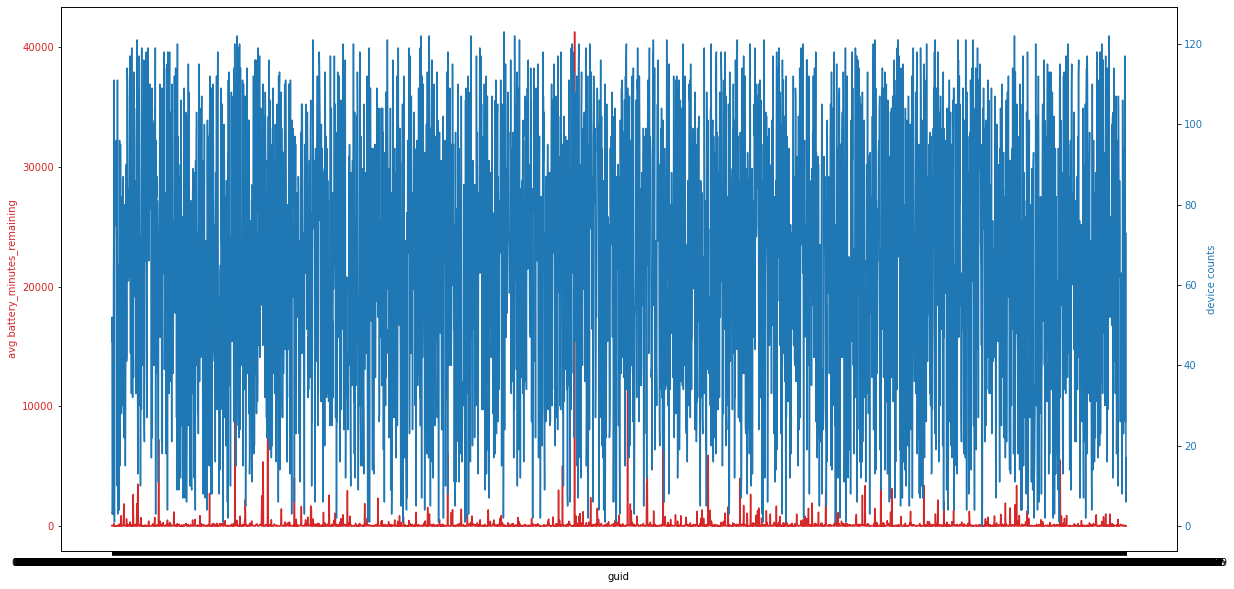

In [15]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# data2 = device_use.set_index('guid').loc[set(battery_event.guid)].reset_index().groupby(['guid']).name.count().sort_index()
# num_devices = data2.loc[data1.index]


# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('device counts', color=color)
# ax2.plot(data1.index, num_devices, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()


In [18]:
np.corrcoef(data1, num_devices)

array([[ 1.        , -0.00903745],
       [-0.00903745,  1.        ]])

This correlation suggests that our initial guess is right. Also, the negative correlation indicates that there exists a opposite trend between number of devices and battery remaining time. Therefore, we could say that as the number of devices increase, battery remaining time would decrease.

## - process Dataset

## Second guessing: ` battery minutes remaining ` is related with ` number of process `

In [19]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
num_proc = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).proc_name.count().sort_index()

data1 = data1.loc[set(num_proc.index).intersection(data1.index)]
num_proc = num_proc.loc[data1.index]


In [56]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# needed = set(battery_event.guid).intersection(set(process.guid))
# num_proc = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).proc_name.count().sort_index()

# data1 = data1.loc[set(num_proc.index).intersection(data1.index)]
# num_proc = num_proc.loc[data1.index]


# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('process counts', color=color)
# ax2.plot(data1.index, num_proc, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()


In [20]:
np.corrcoef(data1, num_proc)

array([[ 1.      , -0.001405],
       [-0.001405,  1.      ]])

Negative Correlation: 2.33% of change in battery minutes remaining is explained by number of processes. As number of processes increases, battery minutes remaining would decrease;

## Third guessing: ` battery minutes remaining ` is related with ` Average Page Faults `

In [21]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
page_faults = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).page_faults.mean().sort_index()

data1 = data1.loc[set(page_faults.index).intersection(data1.index)]
page_faults = page_faults.loc[data1.index]

In [62]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# needed = set(battery_event.guid).intersection(set(process.guid))
# page_faults = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).page_faults.mean().sort_index()

# data1 = data1.loc[set(page_faults.index).intersection(data1.index)]
# page_faults = page_faults.loc[data1.index]


# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('average page faults', color=color)
# ax2.plot(data1.index, page_faults, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

In [22]:
np.corrcoef(data1, page_faults)

array([[ 1.        , -0.01704054],
       [-0.01704054,  1.        ]])

Negative Correlation: 1.71% of change in battery minutes remaining is explained by average page faults. As number of average page faults increases, battery minutes remaining would decrease;

## Fourth guessing: ` battery minutes remaining ` is related with ` Average Memory`

In [23]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
data2 = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).avg_memory.mean().sort_index()

data1 = data1.loc[set(data2.index).intersection(data1.index)]
avg_memory = data2.loc[data1.index]

In [65]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# needed = set(battery_event.guid).intersection(set(process.guid))
# data2 = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).avg_memory.mean().sort_index()

# data1 = data1.loc[set(data2.index).intersection(data1.index)]
# avg_memory = data2.loc[data1.index]


# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('Average Memory', color=color)
# ax2.plot(data1.index, avg_memory, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

In [24]:
np.corrcoef(data1, avg_memory)

array([[1.       , 0.0050973],
       [0.0050973, 1.       ]])

Positive Correlation: 0.387% of change in battery minutes remaining is explained by average memory. As number of average memory increases, battery minutes remaining would decrease;

## Fifth guessing: ` battery minutes remaining ` is related with `cpu_user_sec	` + `cpu_kernel_sec	`

In [25]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
process['cpu_sec']= process['cpu_user_sec']+process['cpu_kernel_sec']
data2 = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).cpu_sec.mean().sort_index()

data1 = data1.loc[set(data2.index).intersection(data1.index)]
cpu_sec = data2.loc[data1.index]

In [68]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# needed = set(battery_event.guid).intersection(set(process.guid))
# process['cpu_sec']= process['cpu_user_sec']+process['cpu_kernel_sec']
# data2 = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).cpu_sec.mean().sort_index()

# data1 = data1.loc[set(data2.index).intersection(data1.index)]
# cpu_sec = data2.loc[data1.index]


# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('average cpu seconds', color=color)
# ax2.plot(data1.index, cpu_sec, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

In [26]:
np.corrcoef(data1, cpu_sec)

array([[ 1.        , -0.01429796],
       [-0.01429796,  1.        ]])

Negative Correlation: 2.49% of change in battery minutes remaining is explained by average cpu seconds. As number of average cpu seconds increases, battery minutes remaining would decrease;

## - Battery_info Dataset

## Sixth guessing: ` battery minutes remaining ` is related with `full_charge_capacity	`

In [27]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]
needed = set(battery_event.guid).intersection(set(battery_info.guid))
data2 = battery_info.set_index('guid').loc[needed].reset_index().groupby(['guid']).full_charge_capacity.mean().sort_index()
data1 = data1.loc[set(data2.index).intersection(data1.index)]
capacity = data2.loc[data1.index]

In [71]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]
# needed = set(battery_event.guid).intersection(set(battery_info.guid))
# data2 = battery_info.set_index('guid').loc[needed].reset_index().groupby(['guid']).full_charge_capacity.mean().sort_index()
# data1 = data1.loc[set(data2.index).intersection(data1.index)]
# capacity = data2.loc[data1.index]

# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('average full charge capacity', color=color)
# ax2.plot(data1.index, capacity, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

In [28]:
np.corrcoef(data1, capacity)

array([[ 1.       , -0.0015245],
       [-0.0015245,  1.       ]])

Negative Correlation: 0.152% of change in battery minutes remaining is explained by full charged capacity. As number of full charged capacity increases, battery minutes remaining would decrease;

## - hw_metric_histo Dataset

## 7th guessing: ` battery minutes remaining ` is related with `cpu_percent`

In [29]:
cpu_info = cpu.groupby(['guid','name'])['mean'].mean().reset_index(level=[0,1])
cpu_percent = cpu_info.loc[cpu_info.name == 'HW::CORE:C0:PERCENT:']
cpu_centi_temp = cpu_info.loc[cpu_info.name == 'HW::CORE:TEMPERATURE:CENTIGRADE:']

In [30]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

needed = set(data1.index).intersection(set(cpu_percent.guid))
cpu_percent = cpu_percent.set_index('guid').loc[needed]['mean']

data1 = data1.loc[set(cpu_percent.index).intersection(data1.index)]
cpu_percent = cpu_percent.loc[data1.index]

In [85]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# needed = set(data1.index).intersection(set(cpu_percent.guid))
# cpu_percent = cpu_percent.set_index('guid').loc[needed]['mean']

# data1 = data1.loc[set(cpu_percent.index).intersection(data1.index)]
# cpu_percent = cpu_percent.loc[data1.index]

# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('average cpu_percent', color=color)
# ax2.plot(data1.index, cpu_percent, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

In [31]:
np.corrcoef(data1, cpu_percent)

array([[ 1.        , -0.00439981],
       [-0.00439981,  1.        ]])

Negative Correlation: 0.44% of change in battery minutes remaining is explained by CPU utilization per each CPU core. As CPU utilization per each CPU core increases, battery minutes remaining would decrease;

## 8th guessing: ` battery minutes remaining ` is related with `cpu_temperature`

In [35]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

needed = set(data1.index).intersection(set(cpu_centi_temp.guid))
cpu_temp = cpu_centi_temp.set_index('guid').loc[needed]['mean']

data1 = data1.loc[set(cpu_temp.index).intersection(data1.index)]
cpu_temp = cpu_temp.loc[data1.index]

In [89]:
# data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
# data1 = data1.loc[data1>0]

# needed = set(data1.index).intersection(set(cpu_centi_temp.guid))
# cpu_temp = cpu_centi_temp.set_index('guid').loc[needed]['mean']

# data1 = data1.loc[set(cpu_temp.index).intersection(data1.index)]
# cpu_temp = cpu_temp.loc[data1.index]

# fig, ax1 = plt.subplots(figsize=(20, 10))
# color = 'tab:red'
# ax1.set_xlabel('guid')
# ax1.set_ylabel('avg battery_minutes_remaining', color=color)
# ax1.plot(data1.index, data1, color=color) 
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('average cpu_temperature', color=color)
# ax2.plot(data1.index, cpu_temp, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

In [36]:
np.corrcoef(data1, cpu_temp)

array([[ 1.        , -0.00499523],
       [-0.00499523,  1.        ]])

Negative Correlation: 0.5% of change in battery minutes remaining is explained by CPU core temperature in centigrade. As CPU core temperature in centigrade increases, battery minutes remaining would decrease;

# Prediction Model

In [37]:
# using all 8 features
X = pd.concat([num_proc, page_faults, capacity, cpu_percent, cpu_temp, num_devices,avg_memory,cpu_sec], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())

In [38]:
# Helper Method1
# calculates the mean absolute error of the given model
def mae(model, X_train, y_train, X_test, y_test):
    reg = model.fit(X_train, y_train)
    train_error = mean_absolute_error(y_train, reg.predict(X_train))
    test_error = mean_absolute_error(y_test, reg.predict(X_test))
    
    return train_error, test_error


### Baseline Model

In [106]:
# for our baseline model, we will use linear regression for calculating mean absolute error 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)

In [107]:
# linear regression
linear_train, linear_test = mae(LinearRegression(), X_train1, y_train1, X_test1, y_test1)
linear_train,linear_test

(0.25995890524183035, 0.27130546214024254)

### Improving Model 

In [108]:
# decision tree regressor
dt_train, dt_test = mae(DecisionTreeRegressor(),X_train1, y_train1, X_test1, y_test1)
dt_train, dt_test

(6.094813588160747e-07, 0.34514883278485403)

In [109]:
# SVM
svm_train, svm_test = mae(svm.SVR(),X_train1, y_train1, X_test1, y_test1)
svm_train, svm_test

(0.252680830427789, 0.26239728885156943)

In [85]:
# random forest regressor
rf_train, rf_test = mae(RandomForestRegressor(), X_train1, y_train1, X_test1, y_test1)
rf_train,rf_test

(0.10101159347830278, 0.2700493107536115)

In [124]:
# AdaBoosting regressor
ada_train, ada_test = mae(AdaBoostRegressor(), X_train1, y_train1, X_test1, y_test1)
ada_train, ada_test

(0.2665241361808894, 0.2812508967132689)

In [101]:
# Gradient regressor
gradient_train, gradient_test = mae(GradientBoostingRegressor(), X_train1, y_train1, X_test1, y_test1)
gradient_train, gradient_test

(0.2283787651396666, 0.258588108433401)

# Hypo Testing

In [67]:
# helper methods 
# run a simulation to see how different the observed mean absolute error is from the simulation 
def simulation2(model1, model2, X, y):
    errors1 = []
    errors2 = []
    
    for _ in range(1000):
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3)

        reg1 = model1.fit(X_train2, y_train2)
        reg2 = model2.fit(X_train2, y_train2)
        
        errors1.append(mean_absolute_error(y_test2, reg1.predict(X_test2)))
        errors2.append(mean_absolute_error(y_test2, reg2.predict(X_test2)))
        
        
    return (np.array(errors1) - np.array(errors2))

### Hypothesis Testing 1
- Null Hypo: There's no difference in performance between Gradient Boosting Regressor and SVM
- Alternative Hypo: Gradient Boosting Regressor performs better than SVM

In [110]:
observed_gradient_svm = gradient_test - svm_test
observed_gradient_svm

-0.003809180418168412

In [126]:
diffa = simulation2(GradientBoostingRegressor(), svm.SVR(), X, y)
p_gradient_svm = (diffa<observed_gradient_svm).mean()
p_gradient_svm

0.0

Absolute Observed Difference: -0.003809180418168412
P-value: -0.003809180418168412


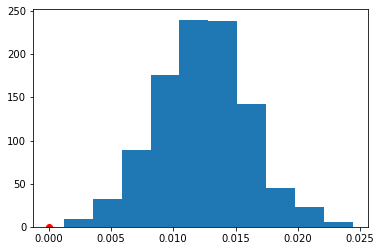

In [127]:
plt.hist(diffa)
print('Absolute Observed Difference: {}'.format(observed_gradient_svm))
print('P-value: {}'.format(observed_gradient_svm))
plt.scatter(p_gradient_svm, 0, c='r')

### Hypothesis Testing 2
- Null Hypo: There's no difference in performance between Gradient Boosting Regressor and AdaBoosting Regressor
- Alternative Hypo: Gradient Boosting Regressor performs better than AdaBoosting Regressor

In [134]:
observed_gradient_ada = gradient_test - ada_test
observed_gradient_ada

-0.012717353706841517

In [137]:
diffb = simulation2(GradientBoostingRegressor(), AdaBoostRegressor(), X, y)
p_gradient_ada = (diffd<observed_gradient_ada).mean()
p_gradient_ada

0.015

Absolute Observed Difference: -0.012717353706841517
P-value: -0.012717353706841517


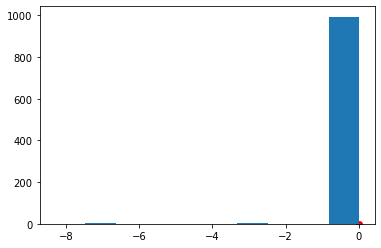

In [138]:
plt.hist(diffb)
print('Absolute Observed Difference: {}'.format(observed_gradient_ada))
print('P-value: {}'.format(observed_gradient_ada))
plt.scatter(p_gradient_ada, 0, c='r')